<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/rl/berater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Berater Environment v13

## Changes from v12 (work in progress)
* port to tfagents with ppo
* openai implementation removed

In [0]:
berater_show_step=False 
berater_show_done=False 
berater_debug_step=False 

## Install tf-agents

In [0]:
!pip install tf-agents-nightly > /dev/null
!pip install tf-nightly > /dev/null

# Define Environment

### Imports

In [0]:
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces

import pdb

### Helper methods

In [0]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    


### Berater Environment (OpenAI Gym)

In [0]:
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions: 
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    
    showStep = False
    showDone = True
    envEpisodeModulo = 100

    def __init__(self):
#         self.map = {
#             'S': [('A', 100), ('B', 400), ('C', 200 )],
#             'A': [('B', 250), ('C', 400), ('S', 100 )],
#             'B': [('A', 250), ('C', 250), ('S', 400 )],
#             'C': [('A', 400), ('B', 250), ('S', 200 )]
#         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200 )],
            'A': [('S', 300), ('B', 100), ('E', 100 ), ('D', 100 )],
            'B': [('S', 100), ('A', 100), ('C', 50 ), ('K', 200 )],
            'C': [('S', 200), ('B', 50), ('M', 100 ), ('L', 200 )],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)
      
        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                             high=high,
                                             dtype=np.float32)
        self.reward_range = (-1, 1)

        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.envReward = 0
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
          return paths[action]
        else:
          # sorry, no such action, stay where you are and pay a high penalty
          return (state, 1000)
      
    def step(self, action):
        if self.debugStep:
          pdb.set_trace()
        destination, cost = self.iterate_path(self.state, action)
        lastState = self.state
        customerReward = self.customer_reward[destination]
        reward = (customerReward - cost) / self.optimum

        self.state = destination
        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())
        if self.stepCount >= 200:
          if BeraterEnv.showDone:
            print("Done: stepCount >= 200")
          done = True

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += reward
        self.stepCount += 1
        self.envReward += reward
        self.envStepCount += 1

        if self.showStep:
            print( "Episode: " + ("%4.0f  " % self.envEpisodeCount) + 
                   " Step: " + ("%4.0f  " % self.stepCount) + 
                   lastState + ' --' + str(action) + '-> ' + self.state + 
                   ' R=' + ("% 2.2f" % reward) + ' totalR=' + ("% 3.2f" % self.totalReward) + 
                   ' cost=' + ("%4.0f" % cost) + ' customerR=' + ("%4.0f" % customerReward) + ' optimum=' + ("%4.0f" % self.optimum)      
                   )

        if done and not self.isDone:
            self.envEpisodeCount += 1
            if BeraterEnv.showDone:
                episodes = BeraterEnv.envEpisodeModulo
                if (self.envEpisodeCount % BeraterEnv.envEpisodeModulo != 0):
                    episodes = self.envEpisodeCount % BeraterEnv.envEpisodeModulo
                print( "Done: " + 
                        ("episodes=%6.0f  " % self.envEpisodeCount) + 
                        ("avgSteps=%6.2f  " % (self.envStepCount/episodes)) + 
                        ("avgTotalReward=% 3.2f" % (self.envReward/episodes) )
                        )
                if (self.envEpisodeCount%BeraterEnv.envEpisodeModulo) == 0:
                    self.envReward = 0
                    self.envStepCount = 0

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}

        return observation, reward, done, info

    def getObservation(self, position):
        result = np.array([ position, 
                               self.getPathObservation(position, 0),
                               self.getPathObservation(position, 1),
                               self.getPathObservation(position, 2),
                               self.getPathObservation(position, 3)
                              ],
                             dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        source = int_to_state_name(position)
        paths = self.map[self.state]
        if path < len(paths):
          target, cost = paths[path]
          reward = self.customer_reward[target] 
          result = reward - cost
        else:
          result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

      
    def modulate_reward(self):
      number_of_customers = len(self.map) - 1
      number_per_consultant = int(number_of_customers/2)
#       number_per_consultant = int(number_of_customers/1.5)
      self.customer_reward = {
          'S': 0
      }
      for customer_nr in range(1, number_of_customers + 1):
        self.customer_reward[int_to_state_name(customer_nr)] = 0
      
      # every consultant only visits a few random customers
      samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
      key_list = list(self.customer_reward.keys())
      for sample in samples:
        self.customer_reward[key_list[sample]] = 1000

      
    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.modulate_reward()
        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))
      
    def render(self):
      print(self.customer_reward)

In [0]:
BeraterEnv.showStep = berater_show_step
BeraterEnv.showDone = berater_show_done
BeraterEnv.debugStep = berater_debug_step

### Register with OpenAI Gym

In [7]:
if not 'isEnvRegistered' in locals():
  env_name="Berater-v1"
  gym.envs.registration.register(id=env_name,entry_point=BeraterEnv,max_episode_steps=1000)
  isEnvRegistered=True
  print("Berater registered as '" + env_name + "'")
else:
  print("Already registered")

Berater registered as 'Berater-v1'


# PPO TF-Agent: setup, train, visualize

### Imports & Helpers

In [0]:
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.dqn import q_network
from tf_agents.agents.ppo import ppo_agent
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network

from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import trajectory
from tf_agents.metrics import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common

from tf_agents.drivers import dynamic_episode_driver
from tf_agents.environments import parallel_py_environment

tf.compat.v1.enable_v2_behavior()


In [0]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):
  old_show_step = BeraterEnv.showStep
  old_show_done = BeraterEnv.showDone
  old_debug_step = BeraterEnv.debugStep
  BeraterEnv.showStep=False
  BeraterEnv.showDone=False
  BeraterEnv.debugStep=False
  
  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  BeraterEnv.showStep=old_show_step
  BeraterEnv.showDone=old_show_done
  BeraterEnv.debugStep=old_debug_step
  return avg_return.numpy()[0]


### Setup and train

In [0]:
BeraterEnv.showStep=False # @param
BeraterEnv.showDone=False # @param

actor_fc_layers=(500,500,500) # @param
value_fc_layers=(500,500,500) # @param


# Params for collect
collect_episodes_per_iteration=100 # @param
num_parallel_environments=1
replay_buffer_capacity=10001  # @param
# Params for train
num_train_iterations=2000 # @param
num_epochs=5 # @param
learning_rate=1e-4 # @param
# Params for summaries and logging
log_interval=1 # @param
use_tf_functions=True
debug_summaries=False
summarize_grads_and_vars=False

num_eval_episodes = 10  # @param
eval_interval = 10  # @param

In [0]:
global_step = tf.compat.v1.train.get_or_create_global_step()
tf.compat.v1.set_random_seed(0)
eval_py_env = suite_gym.load(env_name)
tf_env = tf_py_environment.TFPyEnvironment( suite_gym.load(env_name))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

actor_net = actor_distribution_network.ActorDistributionNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=actor_fc_layers)
value_net = value_network.ValueNetwork(
    tf_env.observation_spec(), fc_layer_params=value_fc_layers)

tf_agent = ppo_agent.PPOAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    optimizer,
    actor_net=actor_net,
    value_net=value_net,
    num_epochs=num_epochs,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
tf_agent.initialize()

eval_py_env = suite_gym.load(env_name)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

collect_policy = tf_agent.collect_policy

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    tf_agent.collect_data_spec,
    batch_size=num_parallel_environments,
    max_length=replay_buffer_capacity)

collect_driver = dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env,
    collect_policy,
    observers=[replay_buffer.add_batch],
    num_episodes=collect_episodes_per_iteration)

collect_driver.run = common.function(collect_driver.run, autograph=False)
tf_agent.train = common.function(tf_agent.train, autograph=False)

In [12]:
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns=[avg_return]
loss=[]

for step in range(num_train_iterations):
  collect_driver.run()
  trajectories = replay_buffer.gather_all()
  total_loss, _ = tf_agent.train(experience=trajectories)
  replay_buffer.clear()

  if step % log_interval == 0:
    print('iteration/train_step = {}, loss = {}'.format(step, total_loss.numpy()))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('iteration/train_step = {}, Average Return = {}'.format(step, avg_return))
    returns.append(avg_return)

iteration/train_step = 0, loss = 5406.33154296875
iteration/train_step = 0, Average Return = -6.139160633087158
iteration/train_step = 1, loss = 5281.330078125
iteration/train_step = 2, loss = 4672.37939453125
iteration/train_step = 3, loss = 4804.7236328125
iteration/train_step = 4, loss = 4077.86767578125
iteration/train_step = 5, loss = 4365.21142578125
iteration/train_step = 6, loss = 3338.60888671875
iteration/train_step = 7, loss = 2409.446533203125
iteration/train_step = 8, loss = 2092.705810546875
iteration/train_step = 9, loss = 1921.863037109375
iteration/train_step = 10, loss = 1472.182373046875
iteration/train_step = 10, Average Return = -3.1566643714904785
iteration/train_step = 11, loss = 1138.1549072265625
iteration/train_step = 12, loss = 986.9594116210938
iteration/train_step = 13, loss = 690.580810546875
iteration/train_step = 14, loss = 346.8659973144531
iteration/train_step = 15, loss = 287.37872314453125
iteration/train_step = 16, loss = 186.26429748535156
iteratio

KeyboardInterrupt: ignored

## Visualize

(-5, 1)

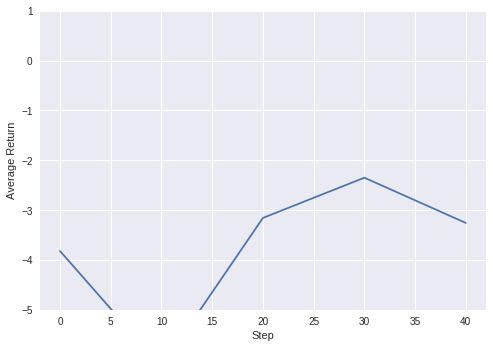

In [20]:
#@test {"skip": true}
import matplotlib
import matplotlib.pyplot as plt


steps = range(0, len(returns)*eval_interval, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=1,bottom=-5)